<a href="https://colab.research.google.com/github/alikaiser12/AI/blob/main/Kernel_%26_radial_basis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: (1200, 10)
       Fe_wt      C_wt     Mn_wt     Cr_wt     Ni_wt  austenitize_temp_C  \
0  96.001230  0.469839  1.349722  1.003187  1.549250          887.109383   
1  96.298746  0.441305  0.831952  1.048519  1.717370          935.478873   
2  95.725862  0.760910  0.901174  0.769796  0.881409          819.505010   

   austenitize_time_min  cool_rate_C_per_s  tensile_strength_MPa phase_label  
0             32.331551          25.510012           1220.707854           M  
1             50.459095          22.286170           1157.749755           M  
2             59.969834           3.296427            676.854285           B  


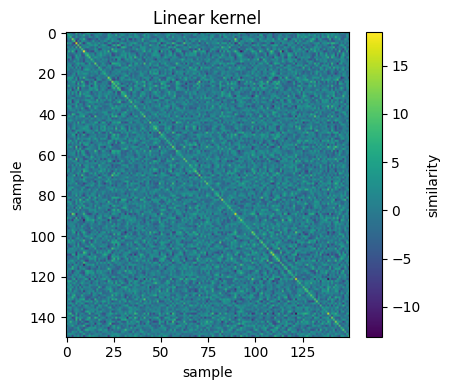

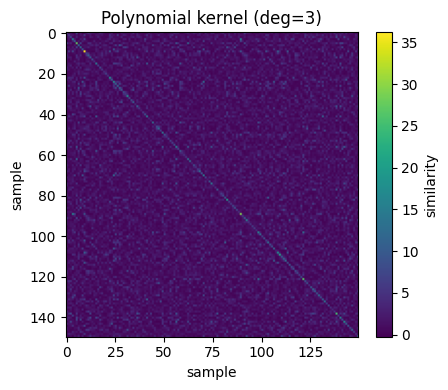

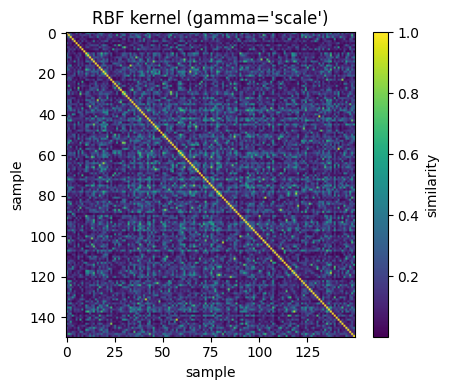

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Kernel Ridge] Best params: {'kr__alpha': 0.1, 'kr__coef0': 1, 'kr__degree': 3, 'kr__kernel': 'polynomial'}
[Kernel Ridge] Test RMSE = 32.33 MPa, R2 = 0.968


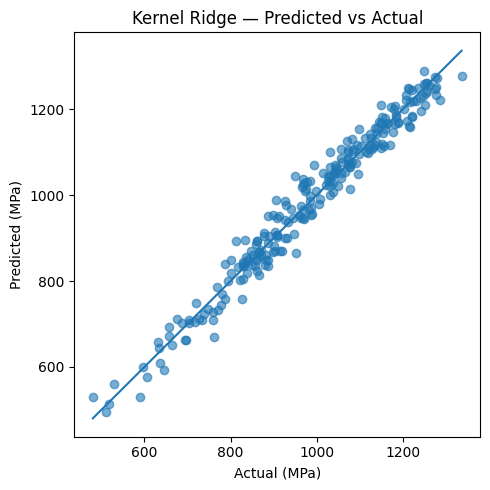

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[SVR(RBF)] Best params: {'svr__C': 30, 'svr__epsilon': 5.0, 'svr__gamma': 'scale'}
[SVR(RBF)] Test RMSE = 60.60 MPa, R2 = 0.889


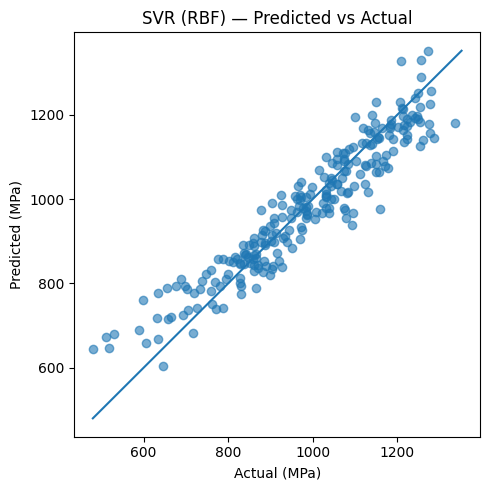

[GPR(RBF)] Test RMSE = 33.53 MPa, R2 = 0.966


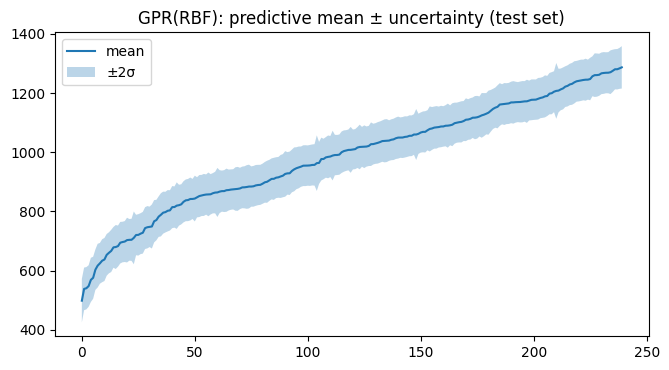

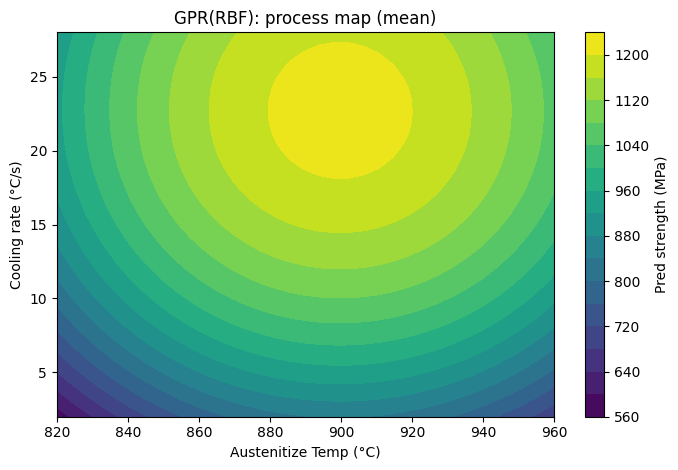

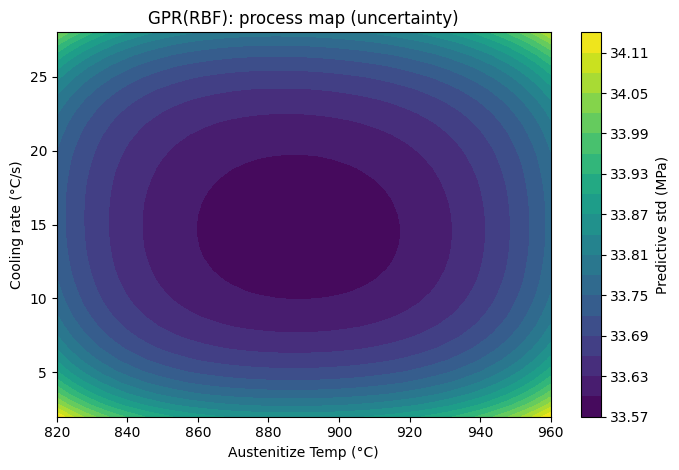

Suggested process (median composition): T≈898.2 °C, q≈22.6 °C/s; mean±std=1217.4±33.6 MPa
[SVC(RBF)] Best params: {'svc__C': 5, 'svc__gamma': 'scale'}
[SVC(RBF)] Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

           B       0.96      0.92      0.94       170
           M       0.83      0.90      0.86        70

    accuracy                           0.92       240
   macro avg       0.89      0.91      0.90       240
weighted avg       0.92      0.92      0.92       240



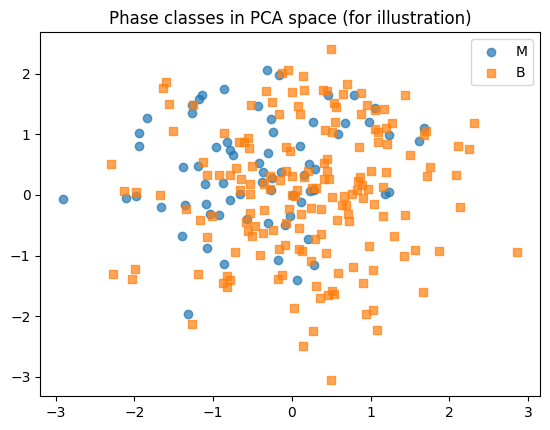

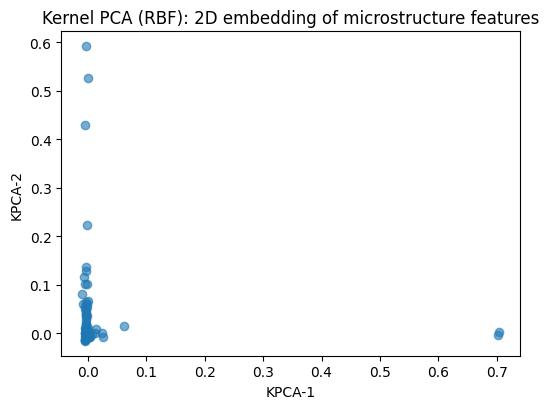


=== Trainer Notes ===

• What is a kernel?  A similarity function that lets linear methods act non‑linearly in feature space.
• Why RBF?  Smooth, local influence; great default for composition‑process‑property problems.
• Hyperparameters: gamma controls locality; larger gamma = narrower influence. Alpha/C regularize complexity.
• Uncertainty matters: use Gaussian Processes (RBF) to map safe/high‑value regions before experiments.
• When to prefer polynomial? When you suspect global smooth polynomials; risk of ringing/overfitting.
• When linear suffices: if preprocessing already encodes nonlinearity or the relation is near‑linear.
• Practical tip: always scale features; search a small, sensible grid for gamma/alpha/C.
• Validation: use K‑fold, watch RMSE and R²; visualize predicted vs actual.
• Deployment: save pipelines with joblib; keep the same scaler when serving models.


Done.


In [3]:
"""
KERNEL METHODS FOR MATERIALS ENGINEERS — TRAINING SCRIPT
=========================================================

Audience: Practicing materials engineers (composition–process–property modeling)
Goal: Teach *kernel methods in general* and the *Radial Basis Function (RBF) kernel* in particular
with hands‑on, end‑to‑end examples that you can run, modify, and extend.

What’s inside (modules you can run separately):
A) Dataset builder (synthetic steel‑like system) or plug‑in your CSV
B) Kernel intuition — build Gram matrices (linear, polynomial, RBF) + heatmaps
C) Regression I — Kernel Ridge (Linear/Poly/RBF) with GridSearchCV
D) Regression II — SVR (RBF) with robust settings
E) Gaussian Processes — RBF kernel with uncertainty + process‑window map
F) Classification — Phase label toy problem with SVC (RBF)
G) Kernel PCA (RBF) — non‑linear feature reduction for microstructure vectors
H) Reusable helpers + trainer notes (talking points & exercises)

Dependencies: numpy, pandas, matplotlib, scikit‑learn
Run: python this_file.py  (or copy cells into a Jupyter notebook)
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.kernel_approximation import RBFSampler

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.decomposition import KernelPCA, PCA

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# ======================================================
# A) DATASET — SYNTHETIC OR YOUR CSV
# ======================================================

USE_SYNTHETIC = True  # set to False to use your own CSV
CSV_PATH = "./materials_training_data.csv"  # when USE_SYNTHETIC=False

FEATURES = [
    "Fe_wt", "C_wt", "Mn_wt", "Cr_wt", "Ni_wt",
    "austenitize_temp_C", "austenitize_time_min", "cool_rate_C_per_s",
]
TARGET = "tensile_strength_MPa"

rng = np.random.default_rng(7)

def make_synthetic_data(n: int = 1200) -> pd.DataFrame:
    Fe = rng.normal(96.0, 1.0, n)
    C  = rng.uniform(0.05, 0.8, n)
    Mn = rng.uniform(0.5, 2.0, n)
    Cr = rng.uniform(0.2, 1.2, n)
    Ni = rng.uniform(0.0, 2.0, n)
    T  = rng.uniform(800, 980, n)
    t  = rng.uniform(10, 60, n)
    q  = rng.uniform(1, 30, n)

    # Nonlinear, physics‑inspired mapping
    base = 350
    carbon = 850 * (C/(0.25+C))
    cooling = 240 * np.tanh((q-6)/7)
    alloy = 55 * np.sqrt(Mn + 0.5*Cr + 0.3*Ni)
    T_peak, T_w = 900, 70
    temp = -200 * ((T - T_peak)/T_w)**2
    soak = -0.6 * np.maximum(t-45, 0)
    noise = rng.normal(0, 28, n)

    y = base + carbon + cooling + alloy + temp + soak + noise

    # Optional phase label for classification demo (toy rule)
    # martensitic if high q and moderate T, bainitic otherwise (toy logic)
    phase = np.where((q>12) & (T>860) & (T<940), "M", "B")

    df = pd.DataFrame({
        "Fe_wt":Fe, "C_wt":C, "Mn_wt":Mn, "Cr_wt":Cr, "Ni_wt":Ni,
        "austenitize_temp_C":T, "austenitize_time_min":t, "cool_rate_C_per_s":q,
        "tensile_strength_MPa":y,
        "phase_label":phase,
    })
    return df

if USE_SYNTHETIC:
    df = make_synthetic_data()
else:
    df = pd.read_csv(CSV_PATH)

print("Dataset:", df.shape)
print(df.head(3))

X = df[FEATURES].copy()
y = df[TARGET].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# ======================================================
# B) KERNEL INTUITION — GRAM MATRICES + HEATMAPS
# ======================================================

from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel

def show_kernel_heatmap(X_sample: pd.DataFrame, title: str, kernel_fn):
    K = kernel_fn(X_sample, X_sample)
    plt.figure(figsize=(4.6,4))
    plt.imshow(K, aspect='auto')
    plt.colorbar(label='similarity')
    plt.title(title)
    plt.xlabel('sample')
    plt.ylabel('sample')
    plt.tight_layout()
    plt.show()

# Use a small standardized sample for visualization
scaler_vis = StandardScaler().fit(X_train)
X_small = scaler_vis.transform(X_train.iloc[:150])

show_kernel_heatmap(X_small, "Linear kernel", linear_kernel)
show_kernel_heatmap(X_small, "Polynomial kernel (deg=3)", lambda A,B: polynomial_kernel(A,B,degree=3))
show_kernel_heatmap(X_small, "RBF kernel (gamma='scale')", lambda A,B: rbf_kernel(A,B,gamma=None))

# Trainer talking point: RBF turns "closeness in feature space" into smooth similarity.

# ======================================================
# C) REGRESSION I — KERNEL RIDGE (Linear/Poly/RBF)
# ======================================================

pre = ColumnTransformer([("scale", StandardScaler(), FEATURES)])

kr = Pipeline([
    ("pre", pre),
    ("kr", KernelRidge())
])

param_grid_kr = [
    {"kr__kernel":["linear"], "kr__alpha":[0.1,1,10]},
    {"kr__kernel":["polynomial"], "kr__alpha":[0.1,1,10], "kr__degree":[2,3], "kr__coef0":[0,1]},
    {"kr__kernel":["rbf"], "kr__alpha":[0.1,1,10], "kr__gamma":[None, 0.1, 0.5, 1.0]},
]

cv = KFold(n_splits=5, shuffle=True, random_state=0)

grid_kr = GridSearchCV(
    kr, param_grid_kr, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1
)

grid_kr.fit(X_train, y_train)

best_kr = grid_kr.best_estimator_
print("[Kernel Ridge] Best params:", grid_kr.best_params_)

y_pred = best_kr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"[Kernel Ridge] Test RMSE = {rmse:.2f} MPa, R2 = {r2_score(y_test, y_pred):.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)
plt.xlabel('Actual (MPa)'); plt.ylabel('Predicted (MPa)')
plt.title('Kernel Ridge — Predicted vs Actual')
plt.tight_layout(); plt.show()

# ======================================================
# D) REGRESSION II — SVR (RBF)
# ======================================================

svr = Pipeline([
    ("pre", pre),
    ("svr", SVR(kernel='rbf'))
])

param_grid_svr = {
    "svr__C": [3, 10, 30],
    "svr__epsilon": [3.0, 5.0, 8.0],
    "svr__gamma": ["scale", 0.2, 0.5, 1.0],
}

grid_svr = GridSearchCV(svr, param_grid_svr, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)

grid_svr.fit(X_train, y_train)

best_svr = grid_svr.best_estimator_
print("[SVR(RBF)] Best params:", grid_svr.best_params_)

y_pred_svr = best_svr.predict(X_test)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
print(f"[SVR(RBF)] Test RMSE = {rmse_svr:.2f} MPa, R2 = {r2_score(y_test, y_pred_svr):.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_svr, alpha=0.6)
lims = [min(y_test.min(), y_pred_svr.min()), max(y_test.max(), y_pred_svr.max())]
plt.plot(lims, lims)
plt.xlabel('Actual (MPa)'); plt.ylabel('Predicted (MPa)')
plt.title('SVR (RBF) — Predicted vs Actual')
plt.tight_layout(); plt.show()

# ======================================================
# E) GAUSSIAN PROCESSES — RBF + UNCERTAINTY
# ======================================================

# Kernel: Constant * RBF + White noise
kernel_gpr = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

gpr = Pipeline([
    ("pre", pre),
    ("gpr", GaussianProcessRegressor(kernel=kernel_gpr, normalize_y=True, n_restarts_optimizer=3, random_state=0))
])

gpr.fit(X_train, y_train)

# Predict with uncertainty: we need transformed X
Xte_proc = gpr.named_steps["pre"].transform(X_test)
mu, std = gpr.named_steps["gpr"].predict(Xte_proc, return_std=True)

print(f"[GPR(RBF)] Test RMSE = {np.sqrt(mean_squared_error(y_test, mu)):.2f} MPa, R2 = {r2_score(y_test, mu):.3f}")

plt.figure(figsize=(6.8,3.8))
idx = np.argsort(mu)
plt.plot(mu[idx], label='mean')
plt.fill_between(np.arange(len(idx)), mu[idx]-2*std[idx], mu[idx]+2*std[idx], alpha=0.3, label='±2σ')
plt.legend(); plt.title('GPR(RBF): predictive mean ± uncertainty (test set)')
plt.tight_layout(); plt.show()

# Process‑window map (fix composition = median; vary T and q)
comp_cols = ["Fe_wt","C_wt","Mn_wt","Cr_wt","Ni_wt"]
fixed = X_train.median(numeric_only=True)
T_grid = np.linspace(820, 960, 35)
q_grid = np.linspace(2, 28, 35)
Tg, qg = np.meshgrid(T_grid, q_grid)

grid = pd.DataFrame({
    **{c: fixed[c] for c in comp_cols},
    "austenitize_temp_C": Tg.ravel(),
    "austenitize_time_min": fixed["austenitize_time_min"],
    "cool_rate_C_per_s": qg.ravel(),
})

Xg = gpr.named_steps["pre"].transform(grid)
mu_g, std_g = gpr.named_steps["gpr"].predict(Xg, return_std=True)

Z_mu = mu_g.reshape(Tg.shape)
Z_sd = std_g.reshape(Tg.shape)

plt.figure(figsize=(7,4.8))
cp = plt.contourf(T_grid, q_grid, Z_mu, levels=20)
plt.colorbar(cp, label='Pred strength (MPa)')
plt.xlabel('Austenitize Temp (°C)'); plt.ylabel('Cooling rate (°C/s)')
plt.title('GPR(RBF): process map (mean)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4.8))
cp2 = plt.contourf(T_grid, q_grid, Z_sd, levels=20)
plt.colorbar(cp2, label='Predictive std (MPa)')
plt.xlabel('Austenitize Temp (°C)'); plt.ylabel('Cooling rate (°C/s)')
plt.title('GPR(RBF): process map (uncertainty)')
plt.tight_layout(); plt.show()

# Simple acquisition: mean - 0.5*std
acq = Z_mu - 0.5*Z_sd
ix = np.unravel_index(np.argmax(acq), acq.shape)
print(f"Suggested process (median composition): T≈{T_grid[ix[1]]:.1f} °C, q≈{q_grid[ix[0]]:.1f} °C/s; mean±std={Z_mu[ix]:.1f}±{Z_sd[ix]:.1f} MPa")

# ======================================================
# F) CLASSIFICATION — SVC (RBF) ON TOY PHASE LABEL
# ======================================================

if "phase_label" in df.columns:
    y_phase = df.loc[X.index, "phase_label"].astype(str)
    Xtr, Xte, ytr, yte = train_test_split(X, y_phase, test_size=0.2, random_state=0, stratify=y_phase)

    svc = Pipeline([
        ("pre", pre),
        ("svc", SVC(kernel='rbf'))
    ])

    grid_svc = GridSearchCV(svc, {
        "svc__C": [1, 5, 20],
        "svc__gamma": ["scale", 0.2, 0.5, 1.0]
    }, cv=cv, n_jobs=-1)

    grid_svc.fit(Xtr, ytr)
    best_svc = grid_svc.best_estimator_
    yhat = best_svc.predict(Xte)
    print("[SVC(RBF)] Best params:", grid_svc.best_params_)
    print("[SVC(RBF)] Accuracy:", accuracy_score(yte, yhat))
    print(classification_report(yte, yhat))

    # Visualize decision in 2D PCA space (educational only)
    p = Pipeline([("pre", pre), ("pca", PCA(n_components=2))])
    Ztr = p.fit_transform(Xtr)
    Zte = p.transform(Xte)

    plt.figure(figsize=(5.6,4.4))
    for lbl, m in [("M", 'o'), ("B", 's')]:
        ii = np.where(yte==lbl)[0]
        plt.scatter(Zte[ii,0], Zte[ii,1], alpha=0.7, marker=m, label=lbl)
    plt.legend(); plt.title('Phase classes in PCA space (for illustration)')
    plt.tight_layout(); plt.show()

# ======================================================
# G) KERNEL PCA (RBF) — MICROSTRUCTURE FEATURE REDUCTION
# ======================================================

# Simulate "microstructure features" (e.g., texture stats, particle descriptors)
M = 500
micro = pd.DataFrame({f"f{i}": rng.normal(0,1,M) for i in range(40)})
# Add a nonlinear cluster structure to make RBF-KPCA shine
micro["f0"] += 2*np.sin(micro["f1"]) + 0.5*(micro["f2"]**2)

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.3, fit_inverse_transform=False)
Z = kpca.fit_transform(micro)

plt.figure(figsize=(5.4,4.2))
plt.scatter(Z[:,0], Z[:,1], alpha=0.6)
plt.title('Kernel PCA (RBF): 2D embedding of microstructure features')
plt.xlabel('KPCA-1'); plt.ylabel('KPCA-2')
plt.tight_layout(); plt.show()

# ======================================================
# H) HELPERS + TRAINER NOTES
# ======================================================

def train_on_csv(csv_path: str, features: list[str], target: str):
    data = pd.read_csv(csv_path)
    X = data[features].copy(); y = data[target].copy()
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=0)

    pre = ColumnTransformer([("scale", StandardScaler(), features)])
    models = {
        "KR_linear": KernelRidge(kernel='linear', alpha=1.0),
        "KR_poly":   KernelRidge(kernel='polynomial', alpha=1.0, degree=3, coef0=1.0),
        "KR_rbf":    KernelRidge(kernel='rbf', alpha=1.0, gamma='scale'),
        "SVR_rbf":   SVR(kernel='rbf', C=10.0, epsilon=5.0, gamma='scale'),
    }
    results = {}
    for name, model in models.items():
        pipe = Pipeline([("pre", pre), ("model", model)])
        pipe.fit(Xtr, ytr)
        yhat = pipe.predict(Xte)
        results[name] = {
            "RMSE": float(np.sqrt(mean_squared_error(yte, yhat))),
            "R2": float(r2_score(yte, yhat))
        }
    return results

TRAINER_TALKING_POINTS = """
• What is a kernel?  A similarity function that lets linear methods act non‑linearly in feature space.
• Why RBF?  Smooth, local influence; great default for composition‑process‑property problems.
• Hyperparameters: gamma controls locality; larger gamma = narrower influence. Alpha/C regularize complexity.
• Uncertainty matters: use Gaussian Processes (RBF) to map safe/high‑value regions before experiments.
• When to prefer polynomial? When you suspect global smooth polynomials; risk of ringing/overfitting.
• When linear suffices: if preprocessing already encodes nonlinearity or the relation is near‑linear.
• Practical tip: always scale features; search a small, sensible grid for gamma/alpha/C.
• Validation: use K‑fold, watch RMSE and R²; visualize predicted vs actual.
• Deployment: save pipelines with joblib; keep the same scaler when serving models.
"""

print("\n=== Trainer Notes ===\n" + TRAINER_TALKING_POINTS)

print("\nDone.")